In [1]:
# External imports
# Module for manipulating arrays
import numpy as np

# Module for loading signals
import soundfile as sf

# Module handling annotations for MIR datasets (including RWC Pop)
import mirdata

# Module to manipulate tensors, used here to unfold/fold tensors.
import tensorly as tl

In [2]:
# Module encapsulating the computation of features from the signal
import barmuscomp.model.features as features

# General module for manipulating data: conversion between time, bars, frame indexes, loading of data, ...
import as_seg.data_manipulation as dm

# Module to process the input in barwise features
import as_seg.barwise_input as bi

# Module encapsulating the NTD computation 
import barmuscomp.lra as lra # The entire NTD code can be obtained in nn_fac.ntd, see this file for more details.

# Module containing our algorithm used for computing the autosimilarity
import as_seg.autosimilarity_computation as as_comp

# Module containing our algorithm used for segmenting the autosimilarity
import as_seg.CBM_algorithm as CBM

# Plotting module
from barmuscomp.model.current_plot import *

# Import default paths
import barmuscomp.scripts.default_path as paths

# Loading the song, and its annotations
As an example, we will load the song "POP-01" of RWC Pop. You need to possess the song in wav format on your own, as we don't share it.

For this code to work automaticaly, you should modify the paths variables in the file `default_path.py` in 'musicntd/scripts', with you own path to the wav files.

You can also change the song_path with any of your own song (as a wav), but it could come without annotations.

In [3]:
# Song
song_path = f"{paths.path_entire_rwc}/1.wav"
the_signal, sampling_rate = sf.read(song_path)

# Estimates the downbeats, with madmom
bars = dm.get_bars_from_audio(song_path)

# Spectrogram
Let's compute the spectrogram of the song. We propose either the Mel Spectrorgram or the Nonnegative Log Mel Spectrogram in this code, but you can chose any other feature (either on the file `features.py`, or by looking at the list on the `librosa` package).

In [5]:
# Variables for the tensor-spectrogram.
hop_length = 32 # Oversampling the spectrogram, to select frames which will be equally-spaced barwise.
subdivision_bars = 96 # Number of frame per bar in the tensor-spectrogram

# Mel Spectrogram ## NB: called "Grill" because it refers to the paper [2].
spectrogram = features.get_spectrogram(the_signal, sampling_rate, "mel_grill", hop_length)
# NN Log Mel Spectrogram
#spectrogram = features.get_spectrogram(the_signal, sampling_rate, "nn_log_mel_grill", hop_length)

# NTD: Nonnegative Tucker Decomposition
Let's compute the Nonnegative Tucker Decomposition of this tensor-spectrogram.

First, we need to set the dimensions of the decomposition, which correspond to the dimensions of the core. They are set empirically here.

In [13]:
core_dimensions = [24,24,24] # Dimensions of the decomposition

## Euclidean norm: $\beta$ = 2
Below is presetned the decomposition obtained with the HALS algorithm, optimizing the euclidean norm ($\beta$-divergence with $\beta = 2$) between the original and the reconstructed tensor.

We plot the matrix $Q^T$, corresponding to the barwise representation of the song in terms of patterns. The patterns are defined by the other factors of the decomposition, $W$, $H$ and slices of $G$.

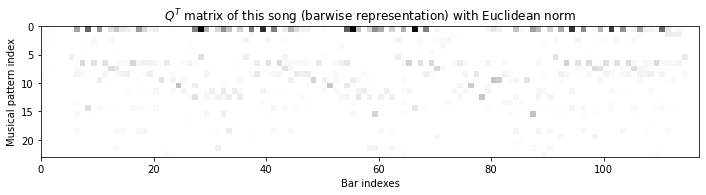

In [14]:
euc_ntd_projection = lra.get_ntd_projection(spectrogram, core_dimensions, bars, beta = 2, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)

# The plotting function below is defined in current_plot.py
plot_permuted_factor(euc_ntd_projection, title = "$Q^T$ matrix of this song (barwise representation) with Euclidean norm", x_axis = "Bar indexes", y_axis = "Musical pattern index")

## $\beta$ = 1
Let's redo this processus with the MU algorithm optimizing the Kullback-Leibler divergence ($\beta$-divergence with $\beta = 1$):

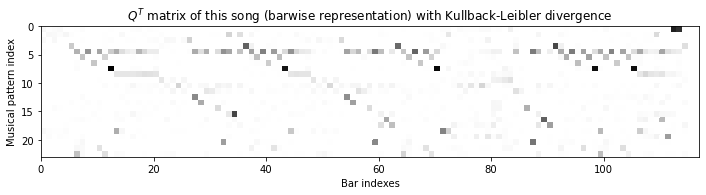

In [17]:
kl_ntd_projection = lra.get_ntd_projection(spectrogram, core_dimensions, bars, beta = 1, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)

# The plotting function below is defined in current_plot.py
plot_permuted_factor(kl_ntd_projection, title = "$Q^T$ matrix of this song (barwise representation) with Kullback-Leibler divergence", x_axis = "Bar indexes", y_axis = "Musical pattern index")

## $\beta = 0$
Let's redo this processus with the MU algorithm optimizing the Itakura-Saito divergence ($\beta$-divergence with $\beta = 0$):

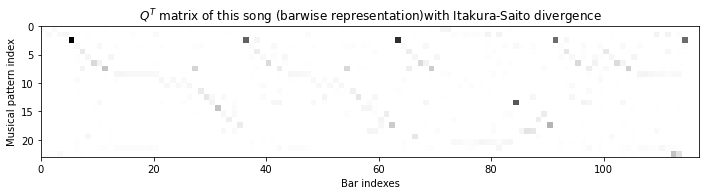

In [20]:
is_ntd_projection = lra.get_ntd_projection(spectrogram, core_dimensions, bars, beta = 0, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)

# The plotting function below is defined in current_plot.py
plot_permuted_factor(is_ntd_projection, title = "$Q^T$ matrix of this song (barwise representation)with Itakura-Saito divergence", x_axis = "Bar indexes", y_axis = "Musical pattern index")